## DataLoader class and data loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from jetnet.datasets import JetNet
from jetnet.utils import to_image
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class DataLoader:
  def __init__(self):
    pass

  def get_data(num_images=70000, Raggio = 0.4, LAST=False, SAVE = False):
    ''' DOWNLOAD DATA '''
    #set args to load the data
    data_args = {
        "jet_type": ["g", "q", "t", "w", "z"],
        # ‘g’ (gluon), ‘q’ (light quarks), ‘t’ (top quarks), ‘w’ (W bosons), or ‘z’ (Z bosons)
        "data_dir": "datasets/jetnet",
        # only selecting the kinematic features
        "particle_features": ["etarel", "phirel", "ptrel"],
        "num_particles": 30,
        "jet_features": ["type"],
        "download": False,
        "split": "all",
    }

    # download as numpy arrays
    particle_data, jet_data = JetNet.getData(**data_args)

    ''' TRANSFORM TO IMAGES '''
    im_size = 50 #pixel size of the length of the image
    maxR=Raggio #maximum radius of the jet
    if LAST == True:
      X_train = np.array( [to_image(particle_data[len(particle_data) - num_images + i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[-num_images:]
    else:
      X_train = np.array( [to_image(particle_data[i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[:num_images]

    if SAVE and LAST:
      np.savez("X_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)
    elif SAVE:
      np.savez("X_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)

    return X_train, Y_train

  def get_data_onehot(train=42000, valid=14000, test=14000, Raggio= 0.4, SAVE = False):
    X_Data, Y_Data = DataLoader.get_data(train+valid, Raggio=Raggio, SAVE = SAVE)
    # data split

    X_train, X_val = X_Data[:train], X_Data[train:]
    Y_train, Y_val = Y_Data[:train], Y_Data[train:]

    X_test, Y_test = DataLoader.get_data(test, Raggio=Raggio, LAST=True, SAVE = SAVE)

    # one hot encoding the lables
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
    Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
    Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

    return X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot

2025-01-24 18:42:09.175763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 18:42:09.249030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 18:42:09.266208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 18:42:09.271128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 18:42:09.338442: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# test
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoader.get_data_onehot(train=200000, valid=50000, test=50000, Raggio = 0.1)

## ModelEval class

In [ ]:
plt.rcParams.update({
    "font.family": "FreeSerif",
    "axes.labelsize": 15,
    "font.size": 15,
    "legend.fontsize": 10,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})

class ModelEval:
  def __init__(self, model, X_test_set, Y_test_set, model_str="model", cmap='inferno'):
    self.X_test = X_test_set
    self.Y_test = Y_test_set
    self.cmap = cmap
    self.model_str = model_str
    self.model = model
    self.array_labels = ["gluon", "light\nquarks", "top\nquark", "W boson", "Z boson"]

    self.Y_test_pred = self.model.predict(self.X_test)
    self.Y_test_pred_classes = np.argmax(self.Y_test_pred, axis=1)
    self.Y_test_classes = np.argmax(self.Y_test, axis=1)

  def Conf_Matrix_and_ROC_curve(self):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.3)

    ''' Confusion Matrix '''
    from sklearn.metrics import confusion_matrix

    conf_m = confusion_matrix(self.Y_test_classes, self.Y_test_pred_classes)
    print("Confusion matrix of " + self.model_str)

    mappable = ax[0].matshow(conf_m, cmap=self.cmap)
    ax[0].set_title("Confusion matrix of " + self.model_str, pad=20)
    ax[0].set_xlabel("Predicted class", labelpad=10)
    ax[0].set_ylabel("True class")
    ax[0].set_xticks(range(5), self.array_labels)
    ax[0].set_yticks(range(5), self.array_labels)
    ax[0].set_aspect('equal')
    fig.colorbar(mappable=mappable, ax=ax[0], shrink=0.85)
    ax[0].xaxis.set_ticks_position("bottom")

    # Add text annotations for each element
    for i in range(conf_m.shape[0]):
        for j in range(conf_m.shape[1]):
            text = ax[0].text(j, i, conf_m[i, j], ha="center", va="center", color="green")

    ''' ROC Curve '''
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    for i in range(5):
      fpr, tpr, thresholds = roc_curve(self.Y_test[:,i], self.Y_test_pred[:, i])
      ax[1].plot(fpr, tpr, linewidth=2, label='{0} (area = {1:0.2f})'.format(self.array_labels[i], round(roc_auc_score(self.Y_test[:,i], self.Y_test_pred[:, i]), 5)))

    ax[1].plot([0, 1], [0, 1], 'k--') # dashed diagonal
    ax[1].grid(1)
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend(fontsize=15)
    ax[1].set_aspect('equal')
    plt.show()

  def accuracy_loss(self, hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.2)

    ax[0].plot(hist['accuracy'], "--", label='Train Accuracy', color="deepskyblue")
    ax[0].plot(hist['val_accuracy'], ".-", label='Validation Accuracy', color="orange")
    ax[0].set_title("Accuracy " + self.model_str, pad=20)
    ax[0].set_xlabel("Epoch", labelpad=10)
    ax[0].legend(fontsize=15)

    ax[1].plot(hist['loss'], "--", label='Train Loss Function', color="deepskyblue")
    ax[1].plot(hist['val_loss'], ".-", label='Validation Loss Function', color="orange")
    ax[1].set_title("Loss function " + self.model_str, pad=20)
    ax[1].set_xlabel("Epoch", labelpad=10)
    ax[1].legend(fontsize=15)
    plt.show()

## DenseNet - definition

In [ ]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_blocks, grow_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.grow_rate = grow_rate
        self.block_layers = []  # Placeholder for layers

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()  # Weight initialization
        for _ in range(self.num_blocks):
            # Define layers for each block
            self.block_layers.append([
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=4 * self.grow_rate, kernel_size=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
                tf.keras.layers.Dropout(0.1),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=self.grow_rate, kernel_size=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
                tf.keras.layers.Dropout(0.1)
            ])

    def call(self, inputs):
        x = inputs
        for block in self.block_layers:
            block_input = x
            for layer in block:
                x = layer(x)
            x = tf.keras.layers.Concatenate(axis=-1)([block_input, x])
        return x

class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, compression=0.9, **kwargs):
        super().__init__(**kwargs)
        self.compression = compression
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = None  # Initialize later when input shape is known
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()
        # Define Conv2D layer here because input_shape is now known
        reduced_filters = int(input_shape[-1] * self.compression)
        self.conv = tf.keras.layers.Conv2D(filters=reduced_filters, kernel_size=(2, 2), padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        super().build(input_shape)

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avg_pool(x)
        return x

In [ ]:
DenseNet = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(50, 50, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters = 20, kernel_size = (3,3), padding= 'same', strides = 1, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'),

    DenseBlock(num_blocks = 8, grow_rate = 10),
    TransitionBlock(),
    DenseBlock(num_blocks = 8, grow_rate = 10),
    TransitionBlock(),
    DenseBlock(num_blocks = 8, grow_rate = 10),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

def lr_schedule1(epoch, lr):
    if epoch < 10:
        return 0.002
    elif epoch < 20:
        return 0.001
    elif epoch < 30:
        return 0.0005
    else:
        return 0.0002

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule1)

DenseNet.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9, nesterov=True, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1737740569.229524   40571 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737740569.240966   40571 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737740569.241210   40571 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737740569.246546   40571 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
DenseNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 50, 50, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 20)     │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block (DenseBlock)        │ (None, 25, 25, 100)    │        86,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_block                │ (None, 12, 12, 90)     │        36,490 │
│ (TransitionBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_1 (DenseBlock)      │ (None, 12, 12, 170)    │       178,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_block_1              │ (None, 6, 6, 153)      │       104,873 │
│ (TransitionBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_2 (DenseBlock)      │ (None, 6, 6, 233)      │       261,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 233)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,993 (2.55 MB)

 Trainable params: 660,643 (2.52 MB)

 Non-trainable params: 8,350 (32.62 KB)

In [ ]:
history = DenseNet.fit(
    X_train,
    Y_train_onehot,
    epochs=40,
    batch_size=64,
    callbacks = lr_callback,
    validation_data=(X_val, Y_valid_onehot))

Epoch 1/40


I0000 00:00:1737740597.017357   42085 service.cc:146] XLA service 0x77ff90002260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737740597.018516   42085 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-24 18:43:17.551939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 18:43:18.467206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100


   4/3125 ━━━━━━━━━━━━━━━━━━━━ 1:34 30ms/step - accuracy: 0.2409 - loss: 1.8845

I0000 00:00:1737740638.773019   42085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 167s 36ms/step - accuracy: 0.4809 - loss: 1.4751 - val_accuracy: 0.3572 - val_loss: 1.8294 - learning_rate: 0.0020
Epoch 2/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.5532 - loss: 1.3222 - val_accuracy: 0.5119 - val_loss: 1.3833 - learning_rate: 0.0020
Epoch 3/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.5726 - loss: 1.2848 - val_accuracy: 0.5151 - val_loss: 1.3774 - learning_rate: 0.0020
Epoch 4/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 93s 30ms/step - accuracy: 0.5849 - loss: 1.2552 - val_accuracy: 0.4732 - val_loss: 1.4435 - learning_rate: 0.0020
Epoch 5/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 93s 30ms/step - accuracy: 0.5912 - loss: 1.2363 - val_accuracy: 0.4852 - val_loss: 1.4065 - learning_rate: 0.0020
Epoch 6/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 93s 30ms/step - accuracy: 0.5998 - loss: 1.2149 - val_accuracy: 0.3412 - val_loss: 3.1924 - learning_rate: 0.0020
Epoch 7/40
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 93s 30ms/step - accuracy: 0.6075

## DenseNet - results

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step


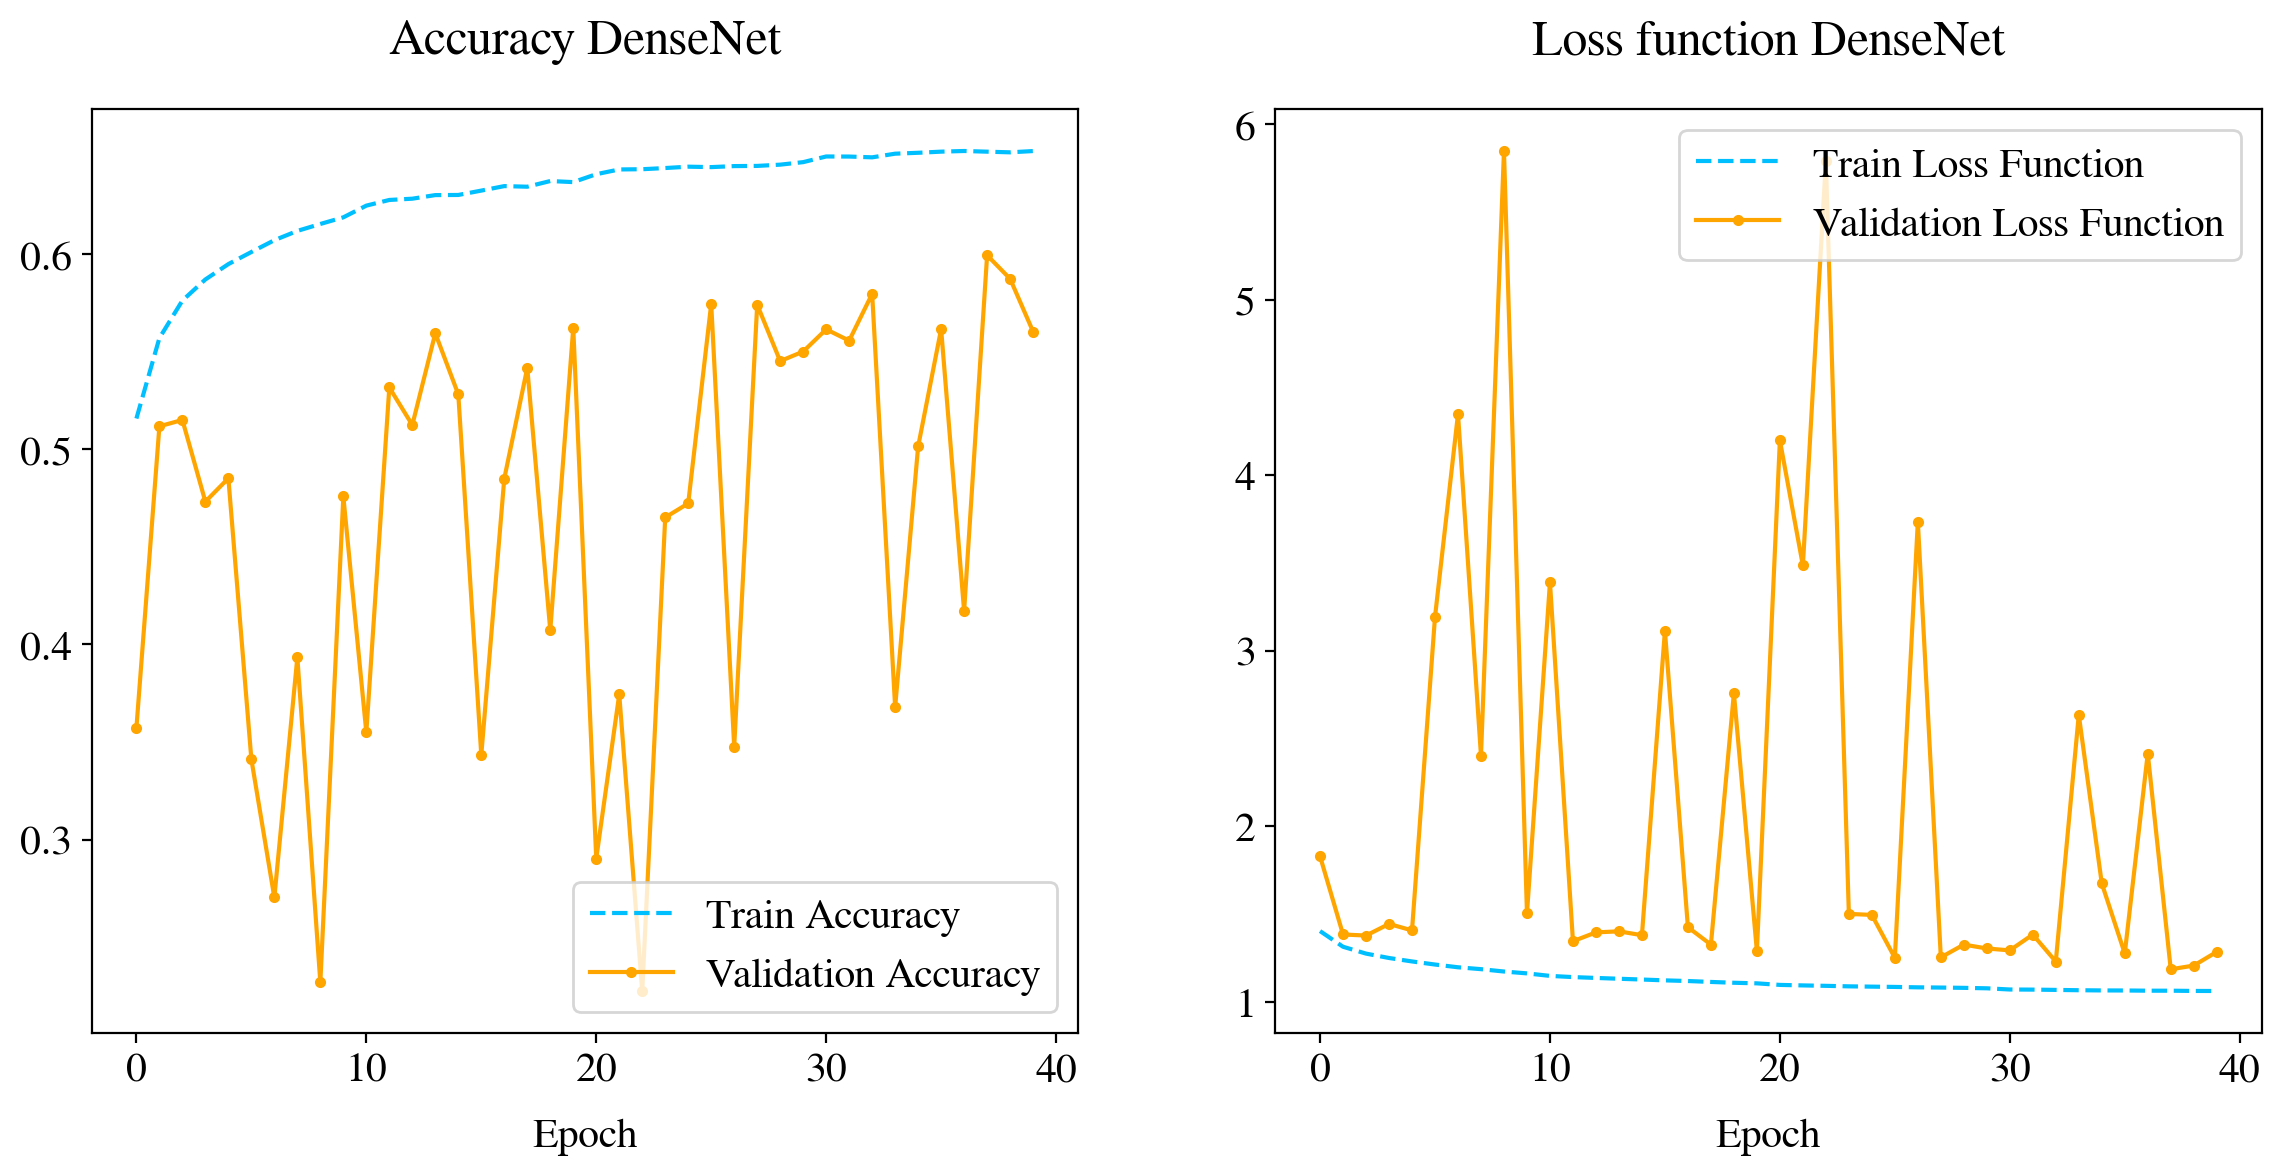

In [ ]:
#class instantiation
m = ModelEval(DenseNet, X_test, Y_test_onehot, model_str="DenseNet")

#methods calling
m.accuracy_loss(pd.DataFrame(history.history))

Confusion matrix of DenseNet


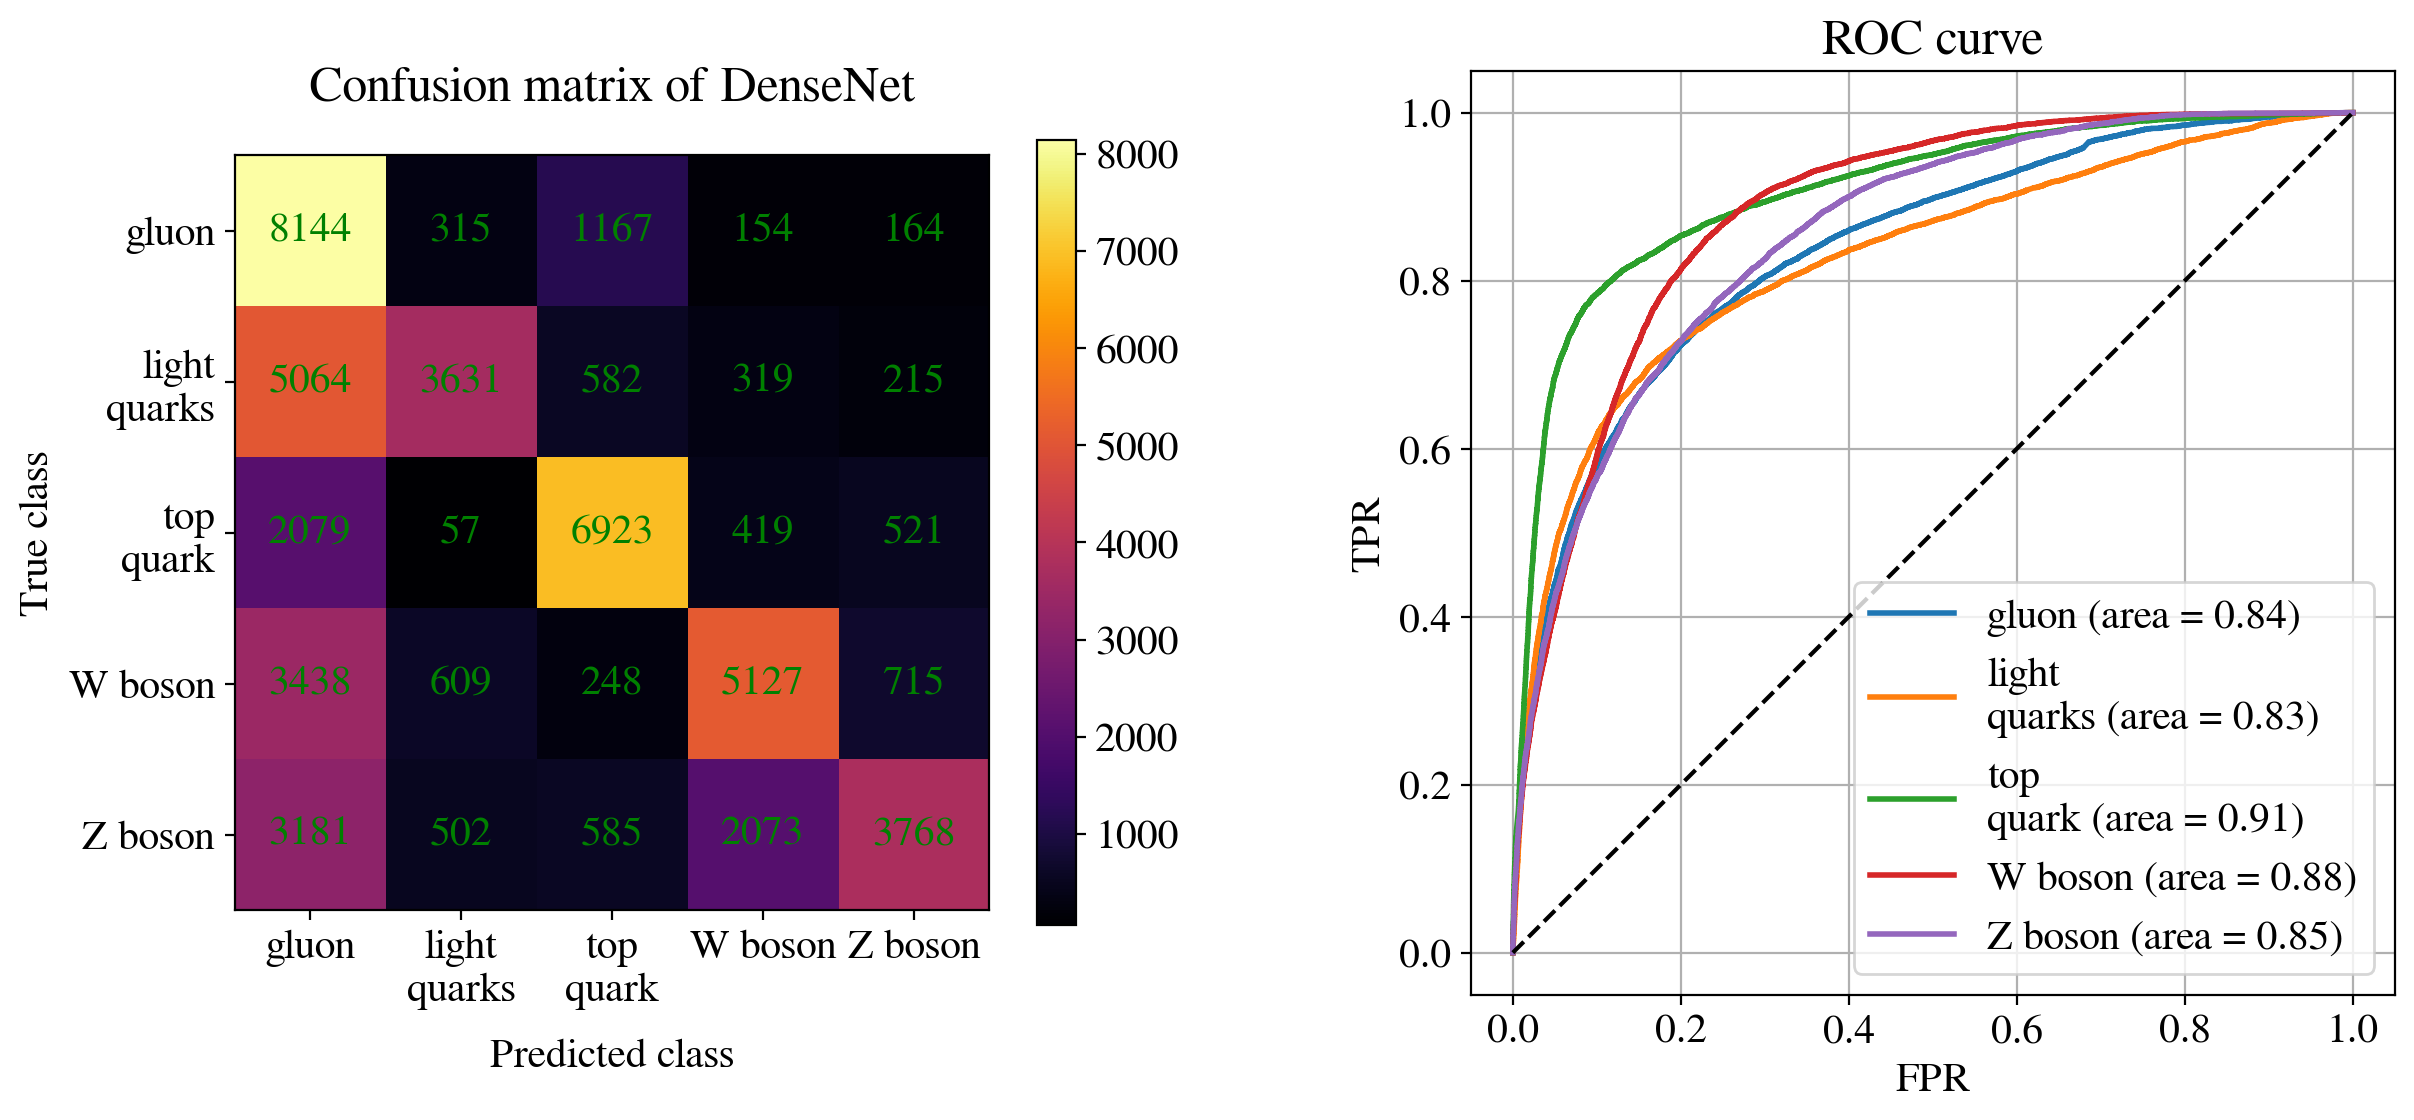

In [ ]:
m.Conf_Matrix_and_ROC_curve()

In [ ]:
loss, accuracy = DenseNet.evaluate(X_test, Y_test_onehot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.3042
Test Accuracy: 0.5519
